# Mobility Data Analysis
1. Scoping
2.  Preprocress the data
3. Explolatory Data Analysis (EDA)
4. Generate user trips and other user attributes
5. Perfom analysis of user data to generate individual level metrics
6. Generate aggregate metrics such as OD

# Project Scoping

#  Python setup
Heree, we import all the required Python packages. In order to use, 
any other module which wasnt ```pip``` installed, such as ```mob_data_utils```,
you  can do the following:
```sys.append(full_path_to_module)```

In [13]:
DATA_DIR = "/home/eze/Documents/mk"

In [14]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import  to_timestamp, to_date
#import pandas as pd
#import random
from pathlib import Path
from pyspark.sql.types import StringType
import os
import random
from pyspark.sql.functions import col, unix_timestamp, date_format as spark_date_format
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, col, min, max, datediff, to_date, substring, countDistinct, count, mean, sqrt, pow
from pyspark.sql.types import TimestampType, StringType
import numpy as np
import glob
from pyspark.sql.window import Window


In [15]:
import importlib.util
import sys

# Modify the path to point to the directory containing mob_data_utils.py
# Assuming mob_data_utils.py is directly inside the TDA folder
mob_dir = os.path.join(DATA_DIR, "mob_data_utils.py")
sys.path.append(mob_dir)

import mob_data_utils as ut

# Setup working directories
Its also important to setup commonly used diretories such as where you will be saving data

In [16]:
# Setup global parameters and variables
MISC_PROCESSING_PARAMS = {'distance_threshold': 2, 'min_unique_locs': 2,'datetime_col': 'datetime',
                        'userid': 'user_id','x': 'lon', 'y': 'lat'}

# Data preprocessing.
Often, after all the data has been  acquired, thee next step is to do some preprocessing on the raw data. 
The objectives of this task will vary depending on the data analysis goals but some of them include following:
- **Sanitize the data:** this data cleaning has to be done carefully to avoid introducing errors but its often a necessary step. It can involve dropping some unnecessary variables/columns. Renaming some columns to something which makes more sense. Dropping some observations. For instance, in this analysis where location and time-stamp is important, dropping all observations with no time-stamp and no location is required.
- **Create new variables:**. If necessary, this is also the time transform some variables from a format which is not convinient for your analysis. For instance, converting string time variables to datetime aware variables.
- **Combine datasets:** If you have more than one dataset, during preprocessing, you can also combine several datasets into one. For instance, we have the CDR transations which have no location details. We bring in the location details from another file.
- **Filtering based on columns and observations:** This can be done through any of the stages mentioned above but its worth mentioning that often, you may drop some columns which arent useful for your analysis. Also, you may drop some observations based on some conditions depending on your analysis needs.

Unlike in other data collection domains such as surveys where you can have standard data processing steps, in the data science space where your dataset can be anything, there are no hard and fast rule for preprocessing and data cleaning. It will be a case by case basis depending on your analysis goals. Also, preprocessing isnt necessarily a linear process: depending on what results you get downstream, you can go back and modify the preprocesisng steps. In this project, we have the ```preprocess_cdrs_using_spark``` which takes raw cdrs and saves to a CSV a processed dataset. Alternatively, we can return a Spark DataFrame.

In [17]:
def preprocess_cdrs_using_spark(file_or_folder=None, number_of_users_to_sample=None,
                                output_csv=None, date_format='yyyyMMddHHmmss',
                                debug_mode=True, loc_file=None, save_to_csv=False):
    """
    In this function, we perfom some basic preprocessing such as below:
    1. rename columns
    2. change some data types
    3. Add location details
    Eventually, we will sample the data to use for our analysis
    :param data_folder:
    :param output_csv_for_sample_users:
    :return:
    """

    # create a SparkSession object
    spark = SparkSession.builder \
        .appName("CDR Preprocessing") \
        .config("spark.driver.memory", "10g") \
        .config("spark.executor.memory", "10g") \
        .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
        .getOrCreate()
    
    # read data with spark
    df = spark.read.option("header", "true").csv(file_or_folder)
    df.printSchema()
    
    # repartition to speed up
    df = df.repartition(20)
    
    # if just testing/debugging, pick only a small dataset
    # by using the sample function of spark
    if debug_mode:
        dfs = df.sample(fraction=0.3) 
        df = dfs
    
    # rename columns to remove space and name them using camel
    # case  sytle like this: cdr datetime becomes cdrDatetime
    # calling phonenumber becomes just phoneNumber
    # if you are renaming more than one column, you can
    # chain the commands and add round brackets like this:
    df2 = df.withColumnRenamed("cdr type", "cdrType") \
           .withColumnRenamed("cdr datetime", "cdrDatetime") \
           .withColumnRenamed("last calling cellid", "lastCallingCellId") \
           .withColumnRenamed("call duration", "callDuration") \
           .withColumnRenamed("user_id", "userId")
    
    # drop the 'cdr type' column
    df3 = df2.drop("cdrType")
    
    # Use Spark UDF to add date and datetime
    add_datetime = None
    add_date = None
    # create timestamp
    df4 = None
    df5 = format_cdr_datetime(df3, date_format)
    
    # lets make sure we dont have any null phoneNumbers
    # use spark filter() function to remove null phoneNumbers
    df6 = df5.filter(col("cdrDatetime").isNotNull() &
                   col("lastCallingCellId").isNotNull() &
                   col("userId").isNotNull())
    
    # Lets merge with location details using cellId from CDRs and also
    # cellID on the other
    # read pandas dataframe of location details
    dfLoc = pd.read_csv(loc_file)
    
    
    # rename column 'cell_id' to 'cellId' in the pandas dataframe
    # YOUR CODE
    dfLoc.rename(columns={'cell_id': 'cellId'}, inplace=True)
    
    # create spark dataframe from the pandas dataframe
    sdfLoc = sdfLoc = spark.createDataFrame(dfLoc)
    
    # join the cdrs dataframe with the location dataframe
    df7 = df6.join(sdfLoc, df6["lastCallingCellId"] == sdfLoc["cellId"], "left")
    
    # create a list of unique user phoneNumbers
        
    all_users = df7.select("userId").distinct().collect()
    
    # randomly select the required number of users
    # using the random.choices() function
    if number_of_users_to_sample is not None:
        random_user_numbers = random.choices(all_users, k=min(number_of_users_to_sample, len(all_users)))
        dfu = df7.filter(col("userId").isin(random_user_numbers) )
    else:
        dfu = df7
    # select only our random user data using spark filter
    # or the type of sampling we did in assignment-2
    dfu = df7.filter(col("lat").isNotNull() & col("lon").isNotNull())
    
    # save to CSV if necessary
    # replace pass and Noen with your code 
    if save_to_csv:
        print(f"Saving processed data into {output_csv}...")
        dfu.write.csv(output_csv, header=True, mode="overwrite")
        print(f"Data well saved into {output_csv}.")
    
    return dfu

In [18]:
#Function to formatted the date

def format_cdr_datetime(df, date_format):
    """
    Formats the 'cdrDatetime' column to a timestamp and adds 'date' and 'cdrDatetime' columns.

    :param df: Input DataFrame containing 'cdrDatetime'
    :param date_format: The format for parsing 'cdrDatetime'
    :return: DataFrame with 'timestamp', 'date', and formatted 'cdrDatetime' columns added
    """
    if df.schema["cdrDatetime"].dataType.typeName() == "long":
        df = df.withColumn("cdrDatetime", col("cdrDatetime").cast("string"))

    # Convert cdrDatetime to timestamp
    df = df.withColumn("timestamp", unix_timestamp(col("cdrDatetime"), date_format).cast("timestamp"))
    df = df.withColumn("date", spark_date_format(col("timestamp"), "yyyy-MM-dd"))
    df = df.withColumn("cdrDatetime", spark_date_format(col("timestamp"), "yyyy-MM-dd HH:mm:ss"))

    return df

In [19]:
# Use DATA_DIR and joinpath as its been used above to create

# full path for simulated_cdrs and loc file
loc_file = os.path.join(DATA_DIR, "simulated_locs.csv")
cdrs_dir = os.path.join(DATA_DIR, "simulated_cdrs")
num_users = None
debug = False
datetime_fmt = None
output_csv = os.path.join(DATA_DIR, "processed_cdrs_output")

# call preprocess_cdrs_using_spark here
# use cache() at the end of the like this preprocess_cdrs_using_spark.cache()
# Learn about what cache does using spark here:
# https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.cache.html#pyspark.sql.DataFrame.cache
dfu = preprocess_cdrs_using_spark(file_or_folder=cdrs_dir, number_of_users_to_sample=num_users,
                                output_csv=output_csv, date_format='yyyyMMddHHmmss',
                                debug_mode=False, loc_file=loc_file, save_to_csv=True).cache()

dfu.show(5)

root
 |-- cdr type: string (nullable = true)
 |-- cdr datetime: string (nullable = true)
 |-- call duration: string (nullable = true)
 |-- last calling cellid: string (nullable = true)
 |-- user_id: string (nullable = true)

Saving processed data into /home/eze/Documents/mk/processed_cdrs_output...
Data well saved into /home/eze/Documents/mk/processed_cdrs_output.
+-------------------+------------+-----------------+-------------------+-------------------+----------+-------+------+---------+---------+
|        cdrDatetime|callDuration|lastCallingCellId|             userId|          timestamp|      date|site_id|cellId|      lat|      lon|
+-------------------+------------+-----------------+-------------------+-------------------+----------+-------+------+---------+---------+
|2018-07-10 20:03:56|        NULL|          34821.0|6501306397541813347|2018-07-10 20:03:56|2018-07-10|   S224| 34821|-8.528478|26.743777|
|2018-07-10 20:04:30|        NULL|          34821.0|8081674521475362040|2018-

# Explolatory Data Analysis (EDA)
Whether the end result of your project is to produce a statistical report or 
to build a prediction model to be put in production, EDA is an essential stage in any data science project. EDA can be defined as 
the process of performing initial investigations on data so as to discover patterns,to spot anomalies,
to test hypothesis and to check assumptions with the help of summary statistics and graphical representations.
It is a good practice to understand the data first and try to gather as many insights from it. 
EDA is all about making sense of data before using the data for the intended use (e.g., build ML models, perfom statisitcal analysis). 

Again, there arent hard and fast rules on how to perfom EDA but some of the specific quesitons you would like to answer are as folloes:
- For each variable in the data, whats its distribution? Is it skewed? Whats its data type? Is it an approapriate  data type fopr my analysis. Are there any outliers?
- Whats the relationship between variables?

In this project, we will use the ```explore_data``` and explore what functions Spark has for basic EDA.

### Generate more summary statistics
Please complete the function below.

In [20]:
def summary_stats_for_user_events(spark_df, out_stats):
    """
    In this function, the goal is to take a big Spark
    DataFrame, group users and count each users events, 
    convert to pandas DataFrame and generate summary stats
    :param: spark_df: preprocessed spark dataframe with data for multiple users
    :param: out_stats: CSV file path to save  the summary stats
    """
    # group user and count number of events
    df_grouped = spark_df.groupBy("userId").agg(count("*").alias("num_events"))
    # convert resulting spark dataframe to pandas
    pdf = df_grouped.toPandas()
    # change column "count" to num_events,remember that pdf is a pandas DataFrame
    pdf = pdf.rename(columns={'count':'num_events'})
    
    # generate summary stats using pandas describe() function
    # use property T to transpose the describe results and convert them
    # into a DataFrame like this: pd.DataFrame(transposed describe results).reset_index()
    # Dont forget to rese_index()
    pdf_sum_stats = pd.DataFrame(pdf['num_events'].describe().T).reset_index()
    
    # remove the first row which has value "count"
    # you can use list indexing to achieve this
    pdf_sum_stats = pdf_sum_stats.iloc[1:]
    
    # Rename the column index into something informative. For instance, "Stat"
    pdf_sum_stats = pdf_sum_stats.rename(columns={'index':'Stat'})
    
    # Rename the percentiles in numbers to something better
    # first, declare a dict with old and new names
    percentile_mapping = {
        '25%':'25th_percentile',
        '50%':'median',
        '75%':'75th_percentile'
    }
    # next, update the Stats column using the pd.Series.map() function
    pdf_sum_stats['Stat'] = pdf_sum_stats['Stat'].map(percentile_mapping).fillna(pdf_sum_stats['Stat'])

    
    print("="*40)
    print("This is the summary statistics table.")
    print("="*40)
    print()
    # please print  the table  below
    print(pdf_sum_stats)
    
    # Now  save the summary stats to CSV
    print(f"Saving processed data into {out_stats}...")
    pdf_sum_stats.to_csv(out_stats, index=False)
    print(f"Data well saved into {out_stats}.")

In [21]:
def total_days_in_dataset(spark_df):
    """
    This function finds the total days in the dataset using the cdrDatetime column.
    """
    
    # calculate the min and max date in dataset using spark aggregate function
    min_date = spark_df.select(min("date"))
    max_date = spark_df.select(max("date"))

    # compute the difference in days using spark function datediff()
    days = spark_df.select(datediff(max("date"),min("date")).alias("day_diff")).first()[0]
    return days

In [22]:
if dfu:
    out_stats_file = os.path.join(DATA_DIR, "user_event_stats.csv")
    summary_stats_for_user_events(dfu, out_stats_file)

    days = total_days_in_dataset(dfu)+1
    print("=" * 40)
    print("Total days in dataset:", days)
    print("=" * 40)
else:
    print("No dataframe to process, please ensure you are not saving to csv")

This is the summary statistics table.

              Stat    num_events
1             mean     15.333054
2              std     37.955597
3              min      1.000000
4  25th_percentile      2.000000
5           median      4.000000
6  75th_percentile     14.000000
7              max  22122.000000
Total days in dataset: 15


# Generate individual based mobility patterns and attributes
As we noted in the project  instructions, the focus of this analysis is to understand mobility patterns 
on individual users. Although, generating trips  and understanding their distribution is crucial for this project, due to time constraints, we will start with simple mobility metrics. Namely:
- **Radius of gyration(Rg):**  For a single day, Rg can be defined in simple terms as the maximum distance a user travels. We can then compute ```avg_Rg``` based on all Rg from the user's data. This metric ```avg_Rg``` is what we will compute.
- **Number of unique locations visited everyday:** As the name suggests, this is simply, the count of unique locations an individual visits everyday. Given multiple days data, we will compute the ```avg_locs_per_day```

In addition to the mobility metric above, we will report the ```number of days``` a user was activive which will help us understand how much we should trust user data. 

For this task, we will utilize functions in the ```mob_data_utils``` module which were already created to generate  the required metrics above. You can import ```mob_data_utils``` like this to use my code: 
```import mob_data_utils as ut```

## Define functions to generate user attributes

In [23]:
def get_basic_user_mob_attributes(df, output_file=None):
        """
        In this funciton, we generate some basic user attributes 
        to help further explore the data and also report on 
        individual mobility metrics.
        :param df: Pandas DataFrame of single user data
        :return:
        """
        # get, datecol, x(lon), y(lat) from the MISC_PROCESSING_PARAMS variable
        datetimecol = MISC_PROCESSING_PARAMS['datetime_col']
        x =  MISC_PROCESSING_PARAMS['x']
        y =  MISC_PROCESSING_PARAMS['y']
        
        # use if condition to 
        if  'date' not in df.columns:
            # add date column in case its not  there
            # use the datetimecol to achieve this
            df['date'] = df[datetimecol].dt.date
        
        # get a list of all  days/dates in ascending order
        # first, sort the dates and then get only unique dates
        dates = sorted(df['date'].unique())
        # this dictionary will keep, for each, a count of unique locations visited
        # initialize this dict with dates as keys and values set to 0
        # you can use list comprehension idea though this is a dictionary
        # Hint, create a list  of unique dates when initializing this dict
        unique_locs_by_day = {date: 0 for date in dates}
        
        # create a dictionary just like above but this one will keep
        # maximum distance travelled for each day
        dates_dist = {date: 0 for date in dates} 
        
        # Loop through the dates_dist dictionary
        for date in dates: 
            # Filter the input df so that we only get data for this date
            dfd = df[df['date'] == date]

            # get number of unique locations for this day
            uniq_xy = ut.va_generate_unique_locs(df=dfd, x=x, y=y)
            # add to the unique_locs_by_day dict, this date based on how
            # you initialized your loop, the value is the number of
            # unique locations visited
            unique_locs_by_day[date] = len(uniq_xy)


            # distances travel
            if len(uniq_xy) > 1:
                dist_mtx = ut.va_distance_matrix(uniq_xy)
                # From the distance matrix above, get only columns with "to"
                # in it, use list comprehension with if condition
                req_cols = [col for col in dist_mtx.columns if "to" in col]
                # get max value from the distance matrix above
                # first, subset the dist_mtx DataDrame by selecting only req_cols
                # then, get values from the resulting DataFrame which you should
                # pass into np.max() function
                # put the resulting max value into the dates_dist dict with this 
                # date as key
                # this can be achieved in a single line of code or multiple lines
                dates_dist[date] = np.max(dist_mtx[req_cols].values)
            else:
                # if number of unique locations is less than or equal to 1
                # then set the value in the dates_dist dict accordingly
                dates_dist[date] = 0
                
        # Prepare results for saving
        results_df = pd.DataFrame({
            'date': dates,
            'unique_locations': [unique_locs_by_day[date] for date in dates],
            'max_distance': [dates_dist[date] for date in dates]
        })
        
        number_of_days = len(dates)

        # Save results to a CSV file if an output file path is provided
        if output_file:
            print(f"Saving processed data into {output_file}...")
            results_df.to_csv(output_file, index=False)
            
            print(f"Data well saved into {output_file}.")

        
        return dates_dist, unique_locs_by_day, number_of_days
        

In [25]:
# Define the directory containing the CSV files
 
directory_path = os.path.join(DATA_DIR, "processed_cdrs_output/")

# Use glob to find all CSV files in the directory
file_pattern = os.path.join(directory_path, '*.csv')
csv_files = glob.glob(file_pattern)

# Read and concatenate all CSV files into a single DataFrame
dfu = pd.concat((pd.read_csv(file) for file in csv_files), ignore_index=True)
outcsv = os.path.join(DATA_DIR, "basic_user_attributes.csv")

# Now  the combined DataFrame to your function
results = get_basic_user_mob_attributes(dfu, outcsv)

# Display or process the results as needed
results

({'2018-06-29': 425.2907455105583,
  '2018-06-30': 425.2907455105583,
  '2018-07-01': 425.2907455105583,
  '2018-07-02': 425.2907455105583,
  '2018-07-03': 425.2907455105583,
  '2018-07-04': 425.2907455105583,
  '2018-07-05': 425.2907455105583,
  '2018-07-06': 425.2907455105583,
  '2018-07-07': 425.2907455105583,
  '2018-07-08': 425.2907455105583,
  '2018-07-09': 425.2907455105583,
  '2018-07-10': 425.2907455105583,
  '2018-07-11': 425.2907455105583,
  '2018-07-12': 425.2907455105583,
  '2018-07-13': 425.2907455105583},
 {'2018-06-29': 84,
  '2018-06-30': 84,
  '2018-07-01': 84,
  '2018-07-02': 84,
  '2018-07-03': 84,
  '2018-07-04': 84,
  '2018-07-05': 84,
  '2018-07-06': 85,
  '2018-07-07': 85,
  '2018-07-08': 85,
  '2018-07-09': 85,
  '2018-07-10': 85,
  '2018-07-11': 85,
  '2018-07-12': 85,
  '2018-07-13': 85},
 15)

 ### Choice of  the mean radius of gyration
   
   
   
   The avg_Rg represents the mean radius of gyration, a metric used to measure the spatial spread of an individual’s movement. It provides insights into how far an individual typically moves from a central point (e.g., home or office). In the context of this dataset, it can help analyze user mobility patterns across different cell towers or geographic locations.
    
#### Why is avg_Rg Relevant?

   **Mobility Patterns:** It quantifies the extent of a user’s mobility, which is particularly useful for applications such as urban planning, transportation analysis, and monitoring public health policies.
    Correlation with Other Metrics: When correlated with avg_locs_per_day, it can provide insights into whether users with more locations visited per day also tend to have higher mobility spreads.

#### How is avg_Rg Typically Calculated?

   **For each user:**
        Compute the geographic centroid (e.g., mean latitude and longitude) of all visited locations.
        Calculate the squared distance of each location from the centroid.
        Average these squared distances and take the square root to get the radius of gyration.

   **For all users:**
        Compute the average of these individual radii of gyration to get avg_Rg.



In [58]:
#We use spark instead of pandas

# Define function to calculate user mobility attributes
def generate_basic_user_attributes_with_spark(input_folder, outcsv, num_events_threshold=None):
    """
    Generate basic user attributes to explore individual mobility metrics.
    :param input_folder: Folder containing input CSV files
    :param outcsv: Output CSV file path
    :param num_events_threshold: Minimum number of events per user to include
    :return: Spark DataFrame with user attributes
    """
    # Initialize Spark session
    spark = SparkSession.builder.appName("UserMobilityAnalysis").getOrCreate()

    # Read all CSV files in the folder into a single DataFrame
    df = spark.read.csv(os.path.join(input_folder, "*.csv"), header=True, inferSchema=True)

    # Calculate radius of gyration for each row
    df = df.withColumn("squared_distance", pow(col("lat") - mean("lat").over(Window.partitionBy("userId")), 2) + \
                                         pow(col("lon") - mean("lon").over(Window.partitionBy("userId")), 2))
    df = df.withColumn("radius_gyration", sqrt(mean("squared_distance").over(Window.partitionBy("userId"))))

    # Calculate basic user mobility metrics
    user_attributes = (
        df.groupBy("userId")
          .agg(
              countDistinct("date").alias("usage_days"),
              (count("cellId") / countDistinct("date")).alias("mean_locs_per_day"),
              mean("radius_gyration").alias("avg_Rg"),
              mean("lat").alias("avg_latitude"),
              mean("lon").alias("avg_longitude")
          )
    )

    # Apply event threshold filter if specified
    if num_events_threshold:
        user_attributes = user_attributes.filter(col("usage_days") >= num_events_threshold)

    # Save the resulting DataFrame to a CSV file
    print(f"Saving processed data into {outcsv}...")
    user_attributes.write.csv(outcsv, header=True, mode="overwrite")
    print(f"Data well saved into {outcsv}.")

    return user_attributes

In [59]:
# Define input folder
SIMULATED_CDRS_DIR = os.path.join(DATA_DIR, "processed_cdrs_output/")
num_events_threshold = 10

# Generate user attributes
outcsv =os.path.join(DATA_DIR, "user_mobility_metrics_with_Rg.csv")
user_attributes_df = generate_basic_user_attributes_with_spark(SIMULATED_CDRS_DIR, outcsv, num_events_threshold=num_events_threshold)

user_attributes_df.to_pandas.head()

Row(userId=13176915433854, usage_days=11, mean_locs_per_day=3.8181818181818183, avg_Rg=0.006862897209384297, avg_latitude=-8.548269047619048, avg_longitude=26.74257928571429)

Correlation between avg_Rg and mean_locs_per_day: 0.015569314979840142


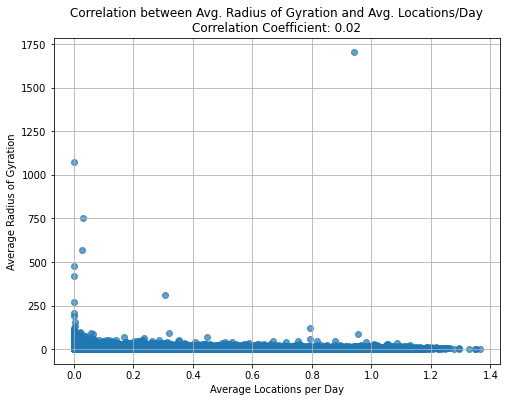

In [60]:
# Load the saved user attributes
spark = SparkSession.builder.getOrCreate()
user_attributes_df = spark.read.csv(outcsv, header=True, inferSchema=True)

# Explore correlation between avg_Rg and mean_locs_per_day
correlation = user_attributes_df.stat.corr("avg_Rg", "mean_locs_per_day")

print(f"Correlation between avg_Rg and mean_locs_per_day: {correlation}")

# Plot the correlation
import matplotlib.pyplot as plt

# Convert Spark DataFrame to Pandas for visualization
user_attributes_pd = user_attributes_df.toPandas()

plt.figure(figsize=(8, 6))
plt.scatter( user_attributes_pd['avg_Rg'],user_attributes_pd['mean_locs_per_day'], alpha=0.7)
plt.title(f"Correlation between Avg. Radius of Gyration and Avg. Locations/Day\nCorrelation Coefficient: {correlation:.2f}")
plt.xlabel("Average Locations per Day")
plt.ylabel("Average Radius of Gyration")
plt.grid(True)
plt.show()

### **Task-4.** What large dataset challenges did you face and how did you solve them. Please explain the decisions you made and why you made them. For example, if you sampled the data, how much of the data did you sample? [ 300 words]


#### The Challenges

   - **Date Formatting Issues:**
        The dataset contained inconsistent or non-standard date formats, causing errors during parsing.
        Spark’s built-in functions often struggled to handle custom date formats or required additional configuration to correctly parse datetime columns. 
        To solve it I utilized Spark’s date_format and to_date functions to normalize and standardize all datetime columns at the preprocessing stage.
        Applied UDFs (User-Defined Functions) where necessary for custom transformations.

   - **Spark Compatibility:**
        Some Python functions or libraries (e.g., datetime for advanced date manipulation) were not directly compatible with Spark DataFrames.
        Complex operations, such as calculating derived mobility metrics, required creative solutions using Spark’s SQL functions and window operations.
        To solve it I replaced Python-based computations with Spark SQL functions to leverage distributed processing.
        Used Spark’s Window functions to calculate metrics like radius of gyration and mobility attributes efficiently.

   - **Java-Related Problems:**
        Spark relies on Java Virtual Machine (JVM), and Java errors surfaced during memory-intensive tasks or operations involving large shuffles (e.g., group-by operations across user data).
        Version mismatches between Spark, Java, and Hadoop libraries occasionally caused runtime errors.
        I solve it by increasing memory allocation for Spark jobs by adjusting JVM parameters (spark.executor.memory and spark.driver.memory).
        Avoided operations that required excessive data shuffling by carefully partitioning and re-partitioning data based on user IDs.

   - **Slowness with Pandas:**
        Pandas struggled with memory-intensive operations, such as reading multiple large CSV files or performing transformations on large subsets of data.
        Debugging and prototyping with Pandas became a bottleneck when transitioning to larger datasets.
        To managed it, I use performed initial prototyping with a small subset of data using Pandas but transitioned fully to Spark for larger-scale processing.
        Spark’s lazy evaluation and distributed nature significantly improved processing speed and reduced memory consumption.

   - **File I/O Overheads:**
        With nearly 20,000 CSV files and 12GB of data, file reading and writing added significant overhead.
        Ensuring proper directory structures for outputs was also critical to avoid accidental overwrites.
        For that, Read and processed smaller subsets of the dataset in batches during debugging to avoid overwhelming the system.
        Configured output directories to store intermediate and final results separately, reducing potential conflicts and ensuring modularity.


#### The decisions made

- **Create my function to format the date instead of using Spark UDF:**


- **Using Spark instead of using Pandas to generate user attributes:**
        

#### About the size of my dataset if use the whole dataset of 12 GB 

In [ ]:
def generate_basic_user_attributes_with_pandas(df, outcsv, num_events_threshold=None):
    """
        In this funciton, we generate some basic user attributes
        to help further explore the data and also report on
        individual mobility metrics.
        :param df: Pandas DataFrame with multiple user data
        :return:
        """
    # get userid col name from  MISC_PROCESSING_PARAMS
    userid = None
    # generate a list of unique userid's
    user_list = None
    # initialize an empty list to hold user  data
    user_data = None

    # Loop through all users and generate their attributes
#     YOUR CODE
#         # Filter the input df so that we only get data for this user
#         df_user = None

#         if num_events_threshold:
#             if df_user.shape[0] < num_events_threshold:
#                 continue
#             else:
#                 # call the get_basic_user_mob_attributes function here
#                 # YOUR CODE
#         else:
#              # call the get_basic_user_mob_attributes function here
#             # YOUR CODE

#         # get the attributes
#         # create a dictionary with the following keys: 'userid', 'usage_days', 'mean_locs_day'
#         # use appropriate numpy functions to compute  mean as required and set them as values
#         # in the dict
#         user_att = None
#         # add user_att to the user_data list
#         #YOUR CODE

    print("="*40)
    print("This is the top  10  rows of the DataFrame.")
    print("="*40)
    print()
    # please print only the head of  the DataFrame below
    # YOUR CODE

    # create DataFrame using user_data and save it to file (2 lines of code)
    # YOUR CODE